# Classification
Using the feature sets, train machine learning classifiers to identify/predict the 10
most frequent dialogue acts (Use the top 10 from section 3 here).

Note:
- You can decide whether to use the training samples that are not labeled as one of the top 10 dialogue act tags.

Model training. Train 3 models: (1) speech features only (2) text features only (3) speech + text features.

In [4]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression   # baseline model
from sklearn.neural_network import MLPClassifier      # neural net
from sklearn.svm import LinearSVC                     # svm
from xgboost import XGBClassifier                     # ensemble
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

In [4]:
speech_train = pd.read_csv("speech_features_train.csv")
speech_valid = pd.read_csv("speech_features_valid.csv")
speech_test = pd.read_csv("speech_features_test.csv")

In [5]:
print(speech_train.columns)

Index(['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'Min Pitch',
       'Max Pitch', 'Mean Pitch', 'Std Pitch', 'Min Intensity',
       'Max Intensity', 'Mean Intensity', 'Std Intensity', 'Speaking Rate',
       'Jitter', 'Shimmer', 'HNR'],
      dtype='object')


In [9]:
text_train = pd.read_csv("text_features_train.csv")
text_valid = pd.read_csv("text_features_valid.csv")
text_test = pd.read_csv("text_features_test.csv")

In [11]:
print(text_train.columns)

Index(['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'function',
       'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron',
       'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj',
       'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo',
       'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male',
       'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual',
       'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk',
       'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion',
       'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler',
       'utt_len'],
      dtype='object')


In [13]:
# label
print(speech_train['da_tag'].unique())
print(text_valid['da_tag'].unique())

['x' 'sv' 'b' 'sd' '%' 'aa' 'ba' 'fc' 'qy' 'ny']
['x' '%' 'b' 'sd' 'aa' 'sv' 'ba' 'fc' 'qy' 'ny']


In [15]:
print(speech_train['da_tag'].value_counts())

da_tag
x     27024
sd    19149
b      9925
sv     7051
%      4101
aa     3136
qy     1253
ba     1063
ny      771
fc      638
Name: count, dtype: int64


## Preprocessing

### speech-based features

In [19]:
print(len(speech_train))
print(speech_train.isnull().sum())

74111
dialog_id            0
speaker              0
da_tag               0
start_time           0
end_time             0
Min Pitch         5297
Max Pitch         5297
Mean Pitch        5297
Std Pitch         5483
Min Intensity       19
Max Intensity       19
Mean Intensity      19
Std Intensity       26
Speaking Rate       19
Jitter            5444
Shimmer           5721
HNR                418
dtype: int64


In [21]:
print(len(speech_valid))
print(speech_valid.isnull().sum())

19156
dialog_id            0
speaker              0
da_tag               0
start_time           0
end_time             0
Min Pitch         1459
Max Pitch         1459
Mean Pitch        1459
Std Pitch         1502
Min Intensity        6
Max Intensity        6
Mean Intensity       6
Std Intensity        8
Speaking Rate        6
Jitter            1496
Shimmer           1578
HNR                103
dtype: int64


In [23]:
print(len(speech_test))
print(speech_test.isnull().sum())

23540
dialog_id             0
speaker               0
da_tag            23540
start_time            0
end_time              0
Min Pitch          1751
Max Pitch          1751
Mean Pitch         1751
Std Pitch          1819
Min Intensity         7
Max Intensity         7
Mean Intensity        7
Std Intensity         7
Speaking Rate         7
Jitter             1796
Shimmer            1885
HNR                 109
dtype: int64


In [25]:
print(speech_train.describe())

         start_time      end_time     Min Pitch     Max Pitch    Mean Pitch  \
count  74111.000000  74111.000000  68814.000000  68814.000000  68814.000000   
mean     211.760358    214.727382    121.546512    307.359646    178.492597   
std      142.616510    142.442332     60.295487    155.145703     69.885105   
min        0.000000      0.040000     57.912219     74.411592     74.411592   
25%       98.426131    101.004500     81.999263    182.616546    126.098842   
50%      195.113540    197.912440     99.589142    260.468986    168.545832   
75%      288.815200    291.558925    146.729688    445.509176    211.182780   
max      601.083682    601.880000    599.402210    642.418440    599.583427   

          Std Pitch  Min Intensity  Max Intensity  Mean Intensity  \
count  68628.000000   74092.000000   74092.000000    74092.000000   
mean      42.050122      12.173880      61.487032       42.213149   
std       39.115378      77.763501      16.535848       31.306063   
min        0

In [27]:
# fill missing value
def fill_missing_values(df, group_cols, features_cols):
    group_means = df.groupby(group_cols)[features_cols].transform("mean")

    df_filled = df.copy()
    df_filled[feature_cols] = df_filled[feature_cols].fillna(group_means)

    df_filled[feature_cols] = df_filled[feature_cols].fillna(df_filled[feature_cols].mean())

    return df_filled


In [29]:
group_cols = ["dialog_id", "speaker"]
feature_cols = ['Min Pitch', 'Max Pitch', 'Mean Pitch', 'Std Pitch', 
                'Min Intensity','Max Intensity', 'Mean Intensity', 'Std Intensity', 
                'Speaking Rate', 'Jitter', 'Shimmer', 'HNR']
speech_train = fill_missing_values(speech_train, group_cols, feature_cols)
speech_valid = fill_missing_values(speech_valid, group_cols, feature_cols)
speech_test = fill_missing_values(speech_test, group_cols, feature_cols)

In [31]:
print(len(speech_train))
print(speech_train.isnull().sum())

74111
dialog_id         0
speaker           0
da_tag            0
start_time        0
end_time          0
Min Pitch         0
Max Pitch         0
Mean Pitch        0
Std Pitch         0
Min Intensity     0
Max Intensity     0
Mean Intensity    0
Std Intensity     0
Speaking Rate     0
Jitter            0
Shimmer           0
HNR               0
dtype: int64


In [33]:
print(len(speech_valid))
print(speech_valid.isnull().sum())

19156
dialog_id         0
speaker           0
da_tag            0
start_time        0
end_time          0
Min Pitch         0
Max Pitch         0
Mean Pitch        0
Std Pitch         0
Min Intensity     0
Max Intensity     0
Mean Intensity    0
Std Intensity     0
Speaking Rate     0
Jitter            0
Shimmer           0
HNR               0
dtype: int64


In [35]:
print(len(speech_test))
print(speech_test.isnull().sum())

23540
dialog_id             0
speaker               0
da_tag            23540
start_time            0
end_time              0
Min Pitch             0
Max Pitch             0
Mean Pitch            0
Std Pitch             0
Min Intensity         0
Max Intensity         0
Mean Intensity        0
Std Intensity         0
Speaking Rate         0
Jitter                0
Shimmer               0
HNR                   0
dtype: int64


In [37]:
# drop base column

speech_X_train = speech_train.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
speech_y_train = speech_train['da_tag']

speech_X_valid = speech_valid.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
speech_y_valid = speech_valid['da_tag']

speech_X_test = speech_test.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
speech_y_test = speech_test['da_tag']

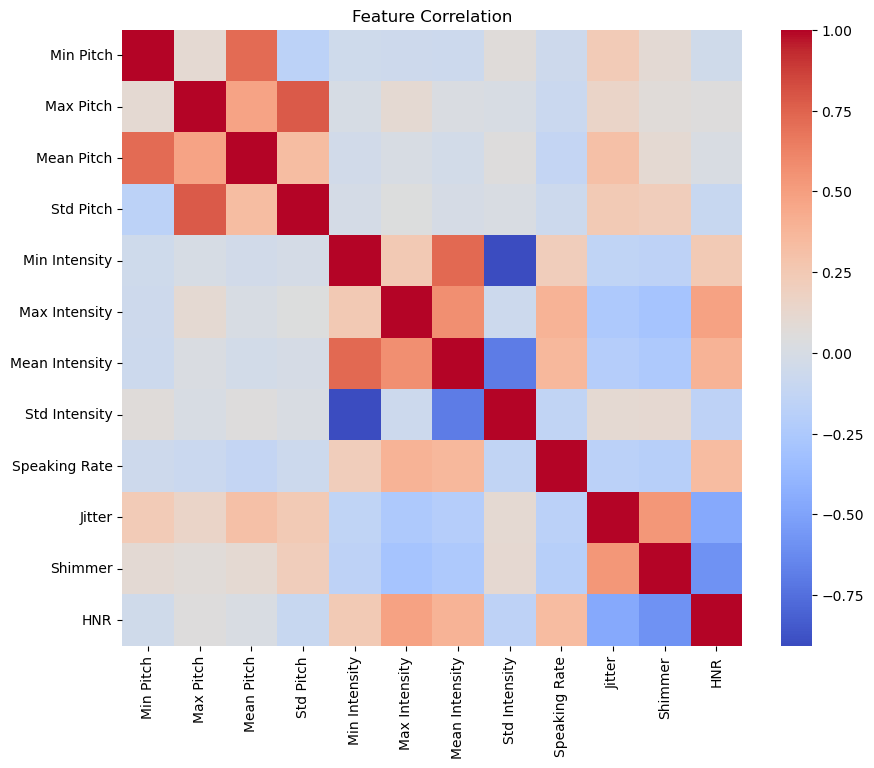

In [39]:
corr = speech_X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

- Mean Pitch (integration: Min Pitch + Max Pitch + Std Pitch)
- Mean Intensity (integration: Min Intensity + Max Intensity)
- Std Intensity
- Speaking Rate
- Shimmer
- Jitter

In [42]:
selected_features = ["Mean Pitch", "Mean Intensity", "Std Intensity", "Speaking Rate", "Shimmer", "Jitter"]

speech_X_train = speech_X_train[selected_features]
speech_X_valid = speech_X_valid[selected_features]
speech_X_test = speech_X_test[selected_features]

In [44]:
# outlier
robust = RobustScaler()

speech_X_train_scaled = robust.fit_transform(speech_X_train)
speech_X_valid_scaled = robust.transform(speech_X_valid)
speech_X_test_scaled = robust.transform(speech_X_test)

In [46]:
# label encoding

le = LabelEncoder()
speech_y_train = le.fit_transform(speech_y_train)
speech_y_valid = le.transform(speech_y_valid)

In [48]:
print(le.classes_)

['%' 'aa' 'b' 'ba' 'fc' 'ny' 'qy' 'sd' 'sv' 'x']


### text-based features

In [51]:
# drop base column

text_X_train = text_train.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
text_y_train = text_train['da_tag']

text_X_valid = text_valid.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
text_y_valid = text_valid['da_tag']

text_X_test = text_test.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
text_y_test = text_test['da_tag']

In [53]:
text_X_train.describe()

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,utt_len
count,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,...,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000
mean,0.289115,0.107398,0.063989,0.031657,0.006904,0.012779,0.004477,0.008172,0.043358,0.021403,...,0.003914,0.000505,0.000354,0.178550,0.000177,0.004235,0.138707,0.038774,0.000324,4.451134
std,0.341576,0.165523,0.122121,0.091034,0.040272,0.050768,0.033077,0.042853,0.106358,0.056716,...,0.026628,0.012158,0.007002,0.360054,0.009819,0.060807,0.340934,0.140743,0.012631,6.701334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.600000,0.200000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,74.000000


In [55]:
# normalization

scaler = StandardScaler()

text_X_train_scaled = scaler.fit_transform(text_X_train)
text_X_valid_scaled = scaler.transform(text_X_valid)
text_X_test_scaled = scaler.transform(text_X_test)

In [57]:
# label encoding

le = LabelEncoder()
text_y_train = le.fit_transform(text_y_train)
text_y_valid = le.transform(text_y_valid)

In [59]:
print(le.classes_)

['%' 'aa' 'b' 'ba' 'fc' 'ny' 'qy' 'sd' 'sv' 'x']


### speech + text

In [62]:
combined_train = pd.merge(speech_train, text_train, on=["dialog_id", "speaker", "da_tag", "start_time", "end_time"])
combined_valid = pd.merge(speech_valid, text_valid, on=["dialog_id", "speaker", "da_tag", "start_time", "end_time"])
combined_test = pd.merge(speech_test, text_test, on=["dialog_id", "speaker", "da_tag", "start_time", "end_time"])

In [64]:
print(combined_train.columns)

Index(['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'Min Pitch',
       'Max Pitch', 'Mean Pitch', 'Std Pitch', 'Min Intensity',
       'Max Intensity', 'Mean Intensity', 'Std Intensity', 'Speaking Rate',
       'Jitter', 'Shimmer', 'HNR', 'function', 'pronoun', 'ppron', 'i', 'we',
       'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak',

In [66]:
print(combined_train.describe())

         start_time      end_time     Min Pitch     Max Pitch    Mean Pitch  \
count  74111.000000  74111.000000  74111.000000  74111.000000  74111.000000   
mean     211.760358    214.727382    121.773573    306.301127    178.116235   
std      142.616510    142.442332     58.430424    150.230336     68.070841   
min        0.000000      0.040000     57.912219     74.411592     74.411592   
25%       98.426131    101.004500     83.134819    189.203683    127.509634   
50%      195.113540    197.912440    101.908181    265.796606    168.681053   
75%      288.815200    291.558925    145.367201    427.131151    210.422608   
max      601.083682    601.880000    599.402210    642.418440    599.583427   

          Std Pitch  Min Intensity  Max Intensity  Mean Intensity  \
count  74111.000000   74111.000000   74111.000000    74111.000000   
mean      41.845506      12.171043      61.487735       42.213653   
std       37.830200      77.759225      16.533849       31.302442   
min        0

In [68]:
# drop base column

combined_X_train = combined_train.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
combined_y_train = combined_train['da_tag']

combined_X_valid = combined_valid.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
combined_y_valid = combined_valid['da_tag']

combined_X_test = combined_test.drop(columns=['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time'])
combined_y_test = combined_test['da_tag']

In [70]:
drop_speech_columns = ['Min Pitch','Max Pitch', 'Std Pitch', 'Min Intensity','Max Intensity','HNR']

combined_X_train = combined_X_train.drop(columns=drop_speech_columns)
combined_X_valid = combined_X_valid.drop(columns=drop_speech_columns)
combined_X_test = combined_X_test.drop(columns=drop_speech_columns)

In [72]:
print(combined_X_train)

       Mean Pitch  Mean Intensity  Std Intensity  Speaking Rate    Jitter  \
0      116.408650       27.565118       9.260265       0.091334  0.013292   
1      112.604750       32.620230       3.578643       0.095963  0.024073   
2      119.122382       36.445984      14.298687       3.706587  0.026665   
3      107.849507       40.632769      12.388610       1.369788  0.021882   
4      103.772805       33.105585       4.226322       0.043702  0.023032   
...           ...             ...            ...            ...       ...   
74106  102.281449       47.554829       4.038130       2.478868  0.007252   
74107  104.203557       48.389527      10.174169       2.630748  0.012267   
74108  106.312529       30.009412       5.310784       0.279068  0.014015   
74109  187.142000       16.756409       2.359147       0.451355  0.032302   
74110  233.663816       58.590685       7.799275       6.169793  0.016199   

        Shimmer  function   pronoun     ppron    i  ...  money  relig  deat

In [74]:
# outlier
robust = RobustScaler()

combined_X_train_scaled = robust.fit_transform(combined_X_train)
combined_X_valid_scaled = robust.transform(combined_X_valid)
combined_X_test_scaled = robust.transform(combined_X_test)

In [76]:
# label encoding

le = LabelEncoder()
combined_y_train = le.fit_transform(combined_y_train)
combined_y_valid = le.transform(combined_y_valid)

## Modeling

In [79]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVM": LinearSVC(max_iter=2000),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8,
                              colsample_bytree=0.8,eval_metric='mlogloss'),
    "NeuralNet": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)
}

In [81]:
def selectModel(models, X_train, y_train, X_valid, y_valid, feature=""):
    print(f"-- {feature} --")
    for name, model in models.items():
      print(f"{name}")
    
      model.fit(X_train, y_train)
    
      train_preds = model.predict(X_train)
      valid_preds = model.predict(X_valid)
    
      train_acc = accuracy_score(y_train, train_preds)
      valid_acc = accuracy_score(y_valid, valid_preds)
    
      train_f1 = f1_score(y_train, train_preds, average = "macro")
      valid_f1 = f1_score(y_valid, valid_preds, average = "macro")
    
      print(f" Train Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
      print(f" Valid Acc: {valid_acc:.4f}, F1: {valid_f1:.4f}\n")

In [83]:
# speech-based classifier
selectModel(models, speech_X_train_scaled, speech_y_train, speech_X_valid_scaled, speech_y_valid, "Speech")

-- Speech --
LogisticRegression
 Train Acc: 0.6334, F1: 0.1967
 Valid Acc: 0.6468, F1: 0.1999

LinearSVM
 Train Acc: 0.6052, F1: 0.1597
 Valid Acc: 0.6196, F1: 0.1600

XGBoost
 Train Acc: 0.6759, F1: 0.2336
 Valid Acc: 0.6844, F1: 0.2277

NeuralNet
 Train Acc: 0.6867, F1: 0.2631
 Valid Acc: 0.6820, F1: 0.2410



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [84]:
# text-based classifier

selectModel(models, text_X_train_scaled, text_y_train, text_X_valid_scaled, text_y_valid, "Text")

-- Text --
LogisticRegression
 Train Acc: 0.8040, F1: 0.5257
 Valid Acc: 0.8146, F1: 0.5334

LinearSVM
 Train Acc: 0.7904, F1: 0.4734
 Valid Acc: 0.8019, F1: 0.4826

XGBoost
 Train Acc: 0.8202, F1: 0.5734
 Valid Acc: 0.8251, F1: 0.5715

NeuralNet
 Train Acc: 0.9088, F1: 0.7342
 Valid Acc: 0.7983, F1: 0.5616



In [85]:
selectModel(models, combined_X_train_scaled, combined_y_train, combined_X_valid_scaled, combined_y_valid, "Speech+Text")

-- Speech+Text --
LogisticRegression
 Train Acc: 0.8030, F1: 0.5173
 Valid Acc: 0.8146, F1: 0.5269

LinearSVM
 Train Acc: 0.7909, F1: 0.4743
 Valid Acc: 0.8017, F1: 0.4818

XGBoost
 Train Acc: 0.8227, F1: 0.5821
 Valid Acc: 0.8249, F1: 0.5711

NeuralNet
 Train Acc: 0.8947, F1: 0.7442
 Valid Acc: 0.8007, F1: 0.5625



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### best model

In [87]:
def plot_cm(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if "norm" in title.lower() else "d",
                xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [106]:
def evaluate(best_model, X_train, y_train, X_valid, y_valid, X_test, label_encoder, feature_type):
    best_model.fit(X_train, y_train)
    valid_preds = best_model.predict(X_valid)
    test_preds = best_model.predict(X_test)

    labels_encoded = sorted(list(np.unique(y_train)))
    labels_ori = le.inverse_transform(labels_encoded)

    
    cm_raw = confusion_matrix(y_valid, valid_preds, labels=labels_encoded)
    cm_norm_true = confusion_matrix(y_valid, valid_preds, normalize="true", labels=labels_encoded)
    cm_norm_pred = confusion_matrix(y_valid, valid_preds, normalize="pred", labels=labels_encoded)
    
    plot_cm(cm_raw, f"{feature_type}-based Classifier's Confusion Matrix (Raw)", labels_ori)
    plot_cm(cm_norm_true, f"{feature_type}-based Classifier's Confusion Matrix (Normalized by True Labels)", labels_ori)
    plot_cm(cm_norm_pred, f"{feature_type}-based Classifier's Confusion Matrix (Normalized by Predicted Labels)", labels_ori)

    return valid_preds, test_preds

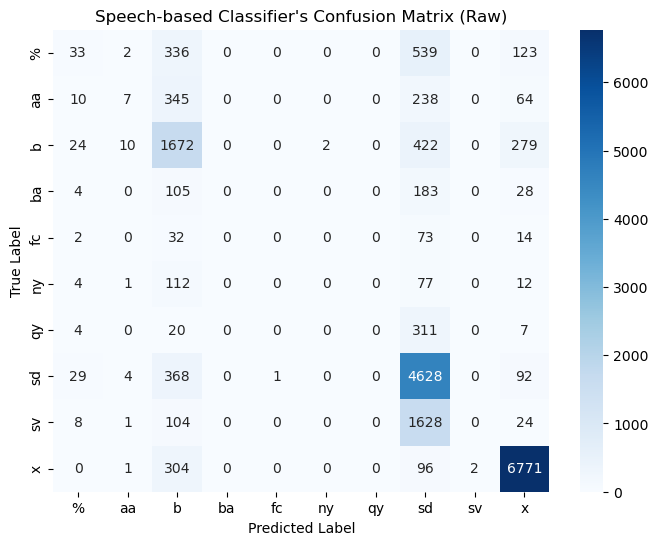

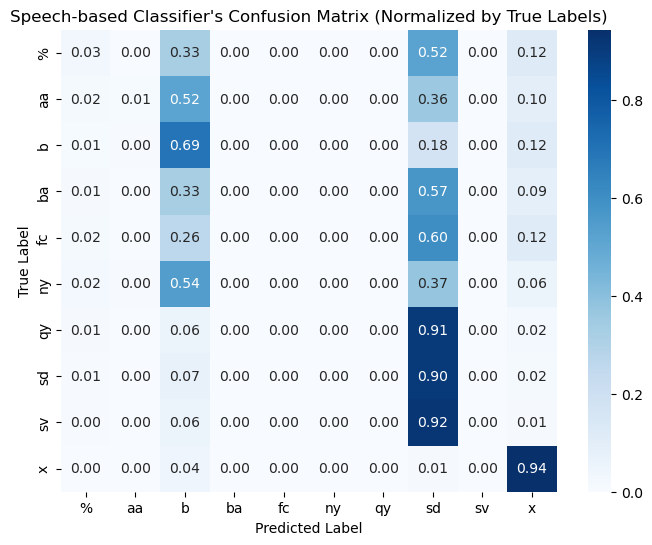

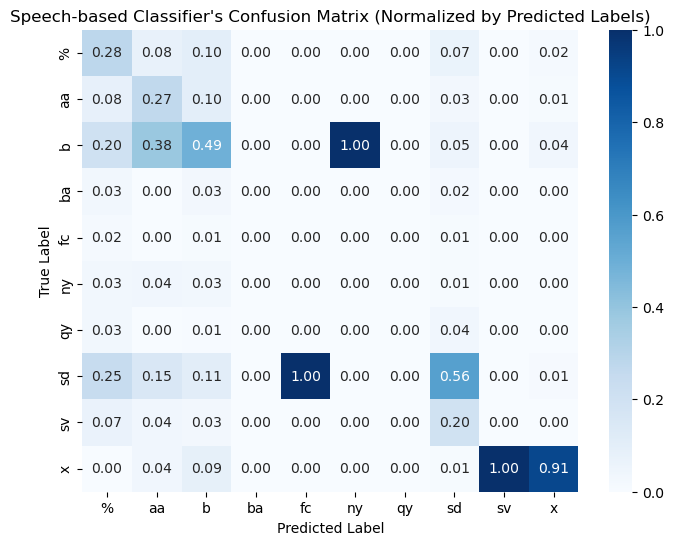

In [108]:
## speech-based classifier

best_speech_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8,
                              colsample_bytree=0.8, eval_metric='mlogloss')
speech_valid_preds, speech_test_preds = evaluate(best_speech_model, speech_X_train_scaled, speech_y_train, 
                           speech_X_valid_scaled, speech_y_valid, speech_X_test_scaled, le, "Speech")

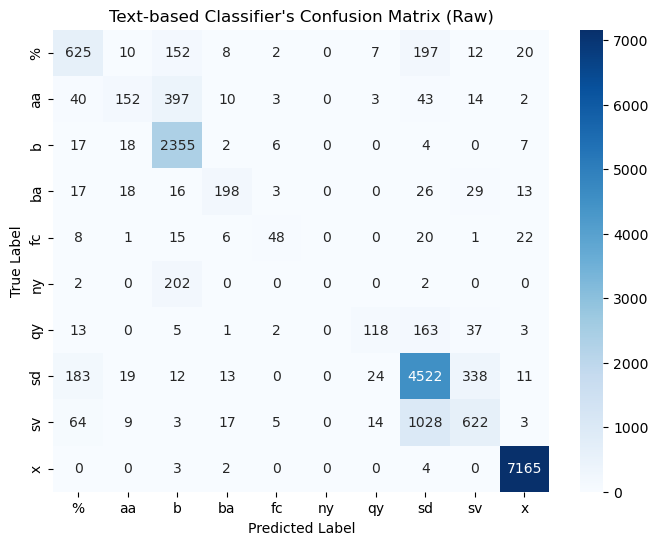

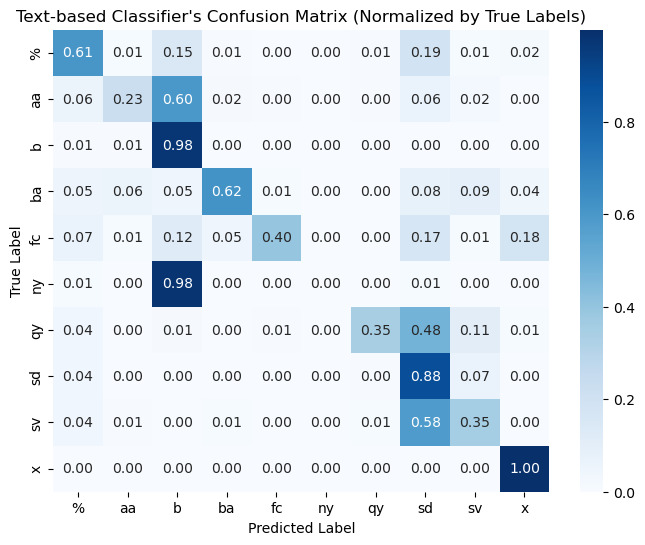

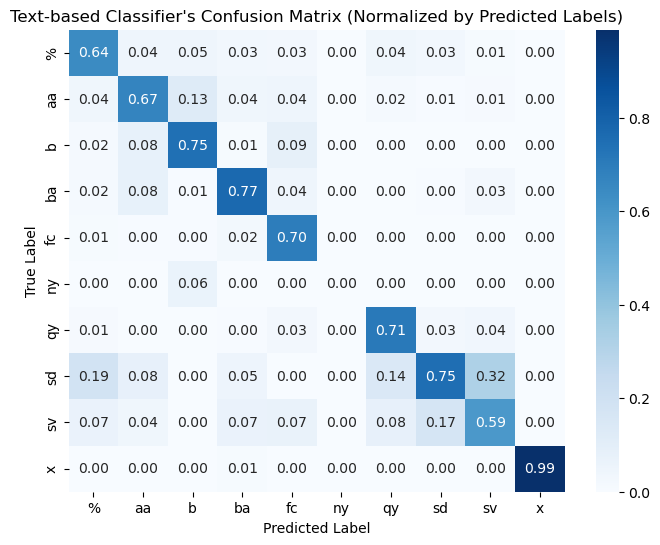

In [110]:
## text-based classifier

best_text_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8,
                              colsample_bytree=0.8, eval_metric='mlogloss')
text_valid_preds, text_test_preds = evaluate(best_text_model, text_X_train_scaled, text_y_train, 
                           text_X_valid_scaled, text_y_valid, text_X_test_scaled, le, "Text")

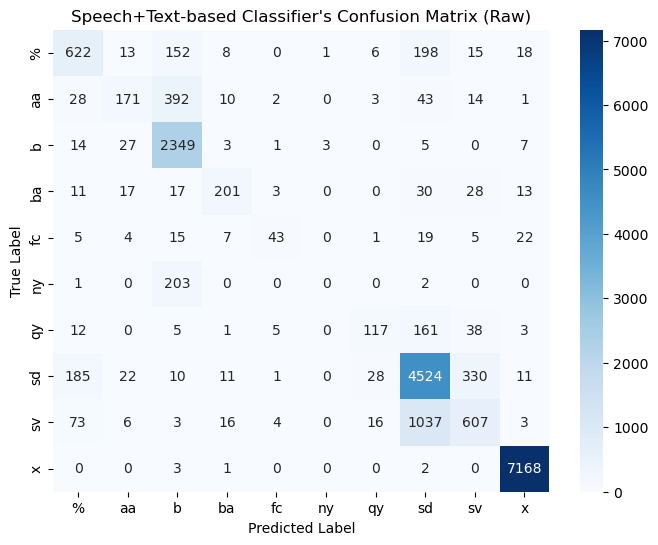

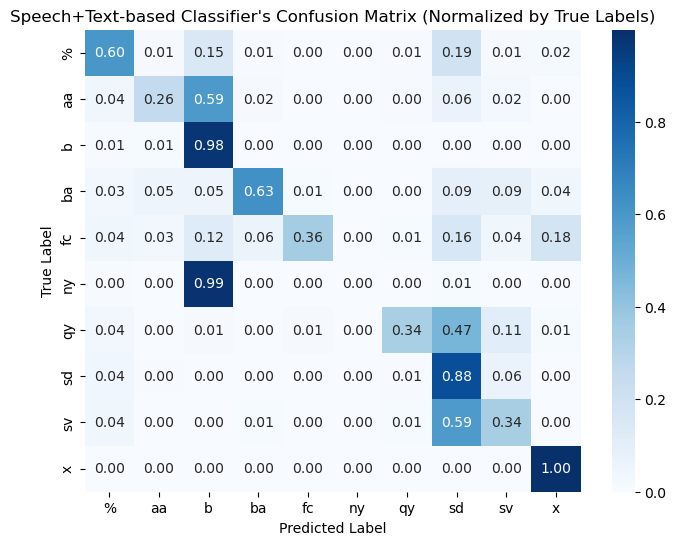

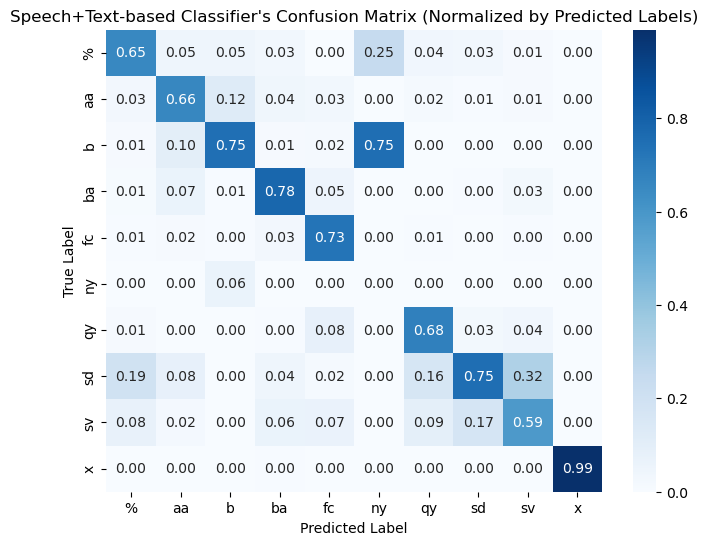

In [112]:
## speech+text-based classifier

best_combined_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8,
                              colsample_bytree=0.8, eval_metric='mlogloss')
combined_valid_preds, combined_test_preds = evaluate(best_combined_model, combined_X_train_scaled, combined_y_train, 
                           combined_X_valid_scaled, combined_y_valid, combined_X_test_scaled, le, "Speech+Text")

In [114]:
# save to csv - columns: ['dialog_id', 'speaker', 'start_time', 'end_time', 'da_tag']

def save_submission(test_df, preds_encoded, label_encoder, output_path):
    preds_decoded = label_encoder.inverse_transform(preds_encoded)

    submission_df = test_df.copy()
    submission_df["da_tag"] = preds_decoded

    submission_df.to_csv(output_path, index=False)

In [116]:
save_submission(text_test, text_test_preds, le, "test_em3907_text.csv")
save_submission(speech_test, speech_test_preds, le, "test_em3907_speech.csv")
save_submission(combined_test, combined_test_preds, le, "test_em3907_multi.csv")

In [122]:
save_submission(text_valid, text_valid_preds, le, "valid_em3907_text.csv")
save_submission(speech_valid, speech_valid_preds, le, "valid_em3907_speech.csv")
save_submission(combined_valid, combined_valid_preds, le, "valid_em3907_multi.csv")

In [129]:
# classification report
def print_classification_report(y_valid, valid_preds, label_encoder, feature_type):
    y_valid_decoded = label_encoder.inverse_transform(y_valid)
    valid_preds_decoded = label_encoder.inverse_transform(valid_preds)

    print(f"\nClassification Report for {feature_type}-based Classifier:")
    print(classification_report(y_valid_decoded, valid_preds_decoded, zero_division=0))

In [131]:
print_classification_report(speech_y_valid, speech_valid_preds, le, "Speech")


Classification Report for Speech-based Classifier:
              precision    recall  f1-score   support

           %       0.28      0.03      0.06      1033
          aa       0.27      0.01      0.02       664
           b       0.49      0.69      0.58      2409
          ba       0.00      0.00      0.00       320
          fc       0.00      0.00      0.00       121
          ny       0.00      0.00      0.00       206
          qy       0.00      0.00      0.00       342
          sd       0.56      0.90      0.70      5122
          sv       0.00      0.00      0.00      1765
           x       0.91      0.94      0.93      7174

    accuracy                           0.68     19156
   macro avg       0.25      0.26      0.23     19156
weighted avg       0.58      0.68      0.61     19156



In [133]:
print_classification_report(text_y_valid, text_valid_preds, le, "Text")


Classification Report for Text-based Classifier:
              precision    recall  f1-score   support

           %       0.64      0.61      0.62      1033
          aa       0.67      0.23      0.34       664
           b       0.75      0.98      0.85      2409
          ba       0.77      0.62      0.69       320
          fc       0.70      0.40      0.51       121
          ny       0.00      0.00      0.00       206
          qy       0.71      0.35      0.46       342
          sd       0.75      0.88      0.81      5122
          sv       0.59      0.35      0.44      1765
           x       0.99      1.00      0.99      7174

    accuracy                           0.83     19156
   macro avg       0.66      0.54      0.57     19156
weighted avg       0.81      0.83      0.80     19156



In [135]:
print_classification_report(combined_y_valid, combined_valid_preds, le, "Speech+Text")


Classification Report for Speech+Text-based Classifier:
              precision    recall  f1-score   support

           %       0.65      0.60      0.63      1033
          aa       0.66      0.26      0.37       664
           b       0.75      0.98      0.85      2409
          ba       0.78      0.63      0.70       320
          fc       0.73      0.36      0.48       121
          ny       0.00      0.00      0.00       206
          qy       0.68      0.34      0.46       342
          sd       0.75      0.88      0.81      5122
          sv       0.59      0.34      0.43      1765
           x       0.99      1.00      0.99      7174

    accuracy                           0.82     19156
   macro avg       0.66      0.54      0.57     19156
weighted avg       0.81      0.82      0.81     19156

